****MScFE Capstone Project****

Student Group 7115
1. Azeez Adekunle Adebayo (azeezadebayo39@gmail.com)
2. Daniel Eseoghene Karakitie (dkarakitie@gmail.com)
3. Fatahi Abiodun Musa (musafatahi3@gmail.com)

**Title: Energy Products Relationship in Different Markets**

**Library Installation**

In [1]:
pip install yfinance pandas numpy matplotlib seaborn scikit-learn statsmodels pmdarima arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 38.7 MB/s eta 0:00:00


**Import Libraries**

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from pmdarima import auto_arima
from scipy.stats import zscore, ttest_ind
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
import itertools
import warnings

warnings.filterwarnings("ignore")

**Define Functions**

In [3]:
# 1.1 Identify and Collect Data Sources
def fetch_market_data(start_date, end_date, ticker_symbol):
    """
    Fetch historical market data for the given ticker symbol between start_date and end_date.
    """
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    return data


# 1.2 Data Cleaning and Preprocessing
def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    df.dropna(inplace=True)  # Remove missing values
    df.index = pd.to_datetime(df.index)  # Ensure the date column is in datetime format
    return df


def detect_and_remove_outliers(df, threshold=3):
    """
    Detects and removes outliers using the Z-score method.
    """
    df_no_outliers = df[(zscore(df) < threshold).all(axis=1)]
    return df_no_outliers


def normalize_data(df, method='zscore'):
    """
    Normalizes data using the specified method: 'zscore' or 'minmax'.
    """
    if method == 'zscore':
        return (df - df.mean()) / df.std()
    elif method == 'minmax':
        return (df - df.min()) / (df.max() - df.min())
    else:
        raise ValueError("Method should be either 'zscore' or 'minmax'")


# 1.3 Exploratory Data Analysis (EDA)
def plot_time_series(df, column='Close', title='Time Series Data'):
    """
    Plots time series data.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[column], label='Close Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


def calculate_descriptive_stats(df):
    """
    Calculate and return descriptive statistics of the dataset.
    """
    return df.describe()


def test_stationarity(df, column='Close'):
    """
    Tests for stationarity of the data using the Augmented Dickey-Fuller test.
    """
    result = adfuller(df[column])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Values: {key}, {value}')
    return result[1]  # Return p-value


# 2.1 Building ARIMA Models
def fit_arima_model(df, column='Close', order=(1, 1, 1)):
    """
    Fits an ARIMA model to the time series data.
    """
    model = ARIMA(df[column], order=order)
    fitted_model = model.fit()
    print(fitted_model.summary())
    return fitted_model


def optimize_arima_params(df, column='Close'):
    """
    Optimizes ARIMA parameters using AIC.
    """
    p = d = q = range(0, 3)
    pdq_combinations = list(itertools.product(p, d, q))
    best_aic = float('inf')
    best_order = None

    for order in pdq_combinations:
        try:
            model = ARIMA(df[column], order=order)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
        except:
            continue

    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    return best_order


# 2.2 Residual Analysis and Validation
def analyze_residuals(model):
    """
    Analyzes the residuals of a fitted ARIMA model.
    """
    residuals = model.resid
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals of ARIMA Model')
    plt.show()
    return residuals


def plot_residuals(residuals):
    """
    Plots the residuals to check for patterns or heteroskedasticity.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals Analysis')
    plt.xlabel('Time')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()


# 2.3 Applying GARCH Models for Volatility Analysis
def fit_garch_model(df, column='Close', order=(1, 1)):
    """
    Applies a GARCH model to the residuals of the ARIMA model.
    """
    model = arch_model(df[column], vol='Garch', p=order[0], q=order[1])
    garch_model = model.fit(disp='off')
    print(garch_model.summary())
    return garch_model


def validate_garch_model(garch_model):
    """
    Validates the GARCH model by checking for ARCH effects.
    """
    test_arch = garch_model.hedgehog_plot()
    return test_arch


# 3.1 Conducting Comparative Analysis Without Segmentation
def compare_volatility(df):
    """
    Compares market volatility without segmentation.
    """
    volatility = df['Close'].pct_change().std()
    print(f"Market Volatility: {volatility}")
    return volatility


# 4.1 Quantifying Volatility Changes (No Segmentation)
def calculate_volatility(df):
    """
    Calculates overall volatility for the entire dataset.
    """
    volatility = df['Close'].pct_change().std()
    print(f'Overall volatility: {volatility}')
    return volatility


def rolling_volatility_analysis(df, column='Close', window_size=30):
    """
    Analyzes rolling volatility using a specified window size.
    """
    rolling_volatility = df[column].pct_change().rolling(window=window_size).std()
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, rolling_volatility, label='Rolling Volatility')
    plt.title('Rolling Volatility Analysis')
    plt.xlabel('Time')
    plt.ylabel('Volatility')
    plt.legend()
    plt.show()
    return rolling_volatility


# 5.1 Cross-Validation of Models
def cross_validate_arima_model(df, column='Close', order=(1, 1, 1), k_folds=5):
    """
    Performs cross-validation on ARIMA model using time-series data.
    """
    tscv = TimeSeriesSplit(n_splits=k_folds)
    errors = []

    for train_index, test_index in tscv.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]

        # Fit the ARIMA model on the training data
        model = ARIMA(train[column], order=order)
        fitted_model = model.fit()

        # Forecast on the test set
        predictions = fitted_model.forecast(steps=len(test))
        error = np.mean((predictions - test[column]) ** 2)  # Mean Squared Error
        errors.append(error)

    mean_error = np.mean(errors)
    print("Cross-validation Mean Squared Error (MSE):", mean_error)
    return mean_error


def sensitivity_analysis_arima(df, column='Close', base_order=(1, 1, 1), variations=[(-1, 0, 0), (0, -1, 0), (0, 0, -1)]):
    """
    Conducts sensitivity analysis on ARIMA model parameters.
    """
    results = {}
    p, d, q = base_order

    for variation in variations:
        var_order = (p + variation[0], d + variation[1], q + variation[2])
        try:
            model = ARIMA(df[column], order=var_order)
            fitted_model = model.fit()
            results[var_order] = {'AIC': fitted_model.aic, 'BIC': fitted_model.bic}
            print(f"Order {var_order} - AIC: {fitted_model.aic}, BIC: {fitted_model.bic}")
        except:
            print(f"Order {var_order} is not a valid model.")
            continue

    return results


# 6.1 Summarizing Findings
def generate_summary_statistics(df):
    """
    Generates summary statistics of the dataset.
    """
    summary = df.describe()
    print("Summary Statistics:", summary)
    return summary

 **STEP 1: Fetching and Cleaning of Data**

1. **Data Collection and Preparation**

**Data Cleaning**

In [4]:
def clean_data(df):
    """
    Cleans the data by handling missing values and standardizing formats.
    """
    df.dropna(inplace=True)  # Remove missing values
    df.index = pd.to_datetime(df.index)  # Ensure the date column is in datetime format
    return df
# Fetch and clean data
df = fetch_market_data('2010-10-01', '2024-10-01', 'CL=F')
df_clean = clean_data(df)

[*********************100%***********************]  1 of 1 completed


In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-01,79.839996,81.690002,79.699997,81.580002,81.580002,359944
2010-10-04,81.680000,82.379997,80.769997,81.470001,81.470001,313306
2010-10-05,81.370003,82.989998,81.150002,82.820000,82.820000,336832
2010-10-06,82.599998,84.089996,82.290001,83.230003,83.230003,349174
2010-10-07,83.269997,84.430000,81.000000,81.669998,81.669998,450952
...,...,...,...,...,...,...
2024-09-24,70.760002,72.400002,70.440002,71.559998,71.559998,318516
2024-09-25,71.540001,71.720001,69.230003,69.690002,69.690002,476237
2024-09-26,69.889999,70.010002,66.949997,67.669998,67.669998,478069


In [6]:
df_clean

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-01,79.839996,81.690002,79.699997,81.580002,81.580002,359944
2010-10-04,81.680000,82.379997,80.769997,81.470001,81.470001,313306
2010-10-05,81.370003,82.989998,81.150002,82.820000,82.820000,336832
2010-10-06,82.599998,84.089996,82.290001,83.230003,83.230003,349174
2010-10-07,83.269997,84.430000,81.000000,81.669998,81.669998,450952
...,...,...,...,...,...,...
2024-09-24,70.760002,72.400002,70.440002,71.559998,71.559998,318516
2024-09-25,71.540001,71.720001,69.230003,69.690002,69.690002,476237
2024-09-26,69.889999,70.010002,66.949997,67.669998,67.669998,478069


Step 2: Exploratory Data Analysis

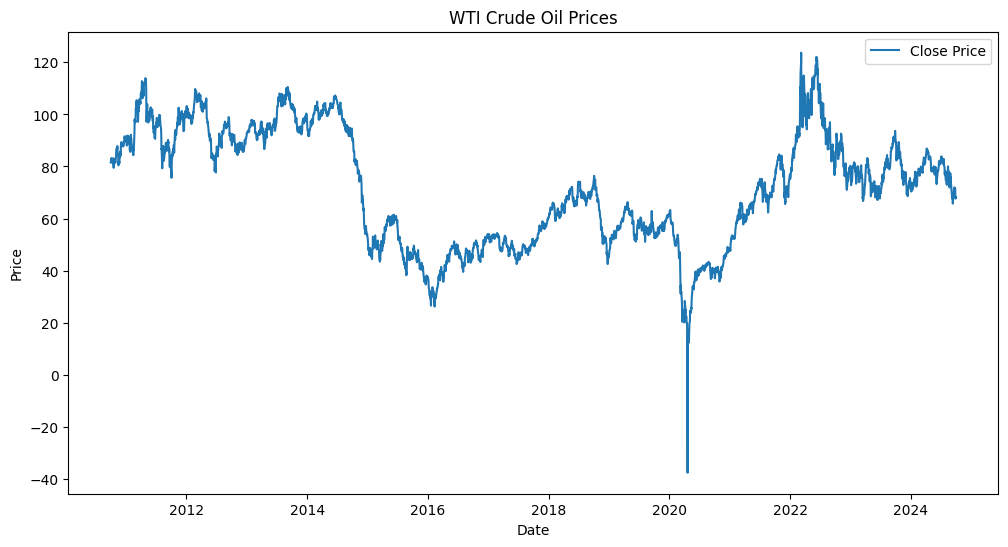

              Open         High          Low        Close    Adj Close  \
count  3520.000000  3520.000000  3520.000000  3520.000000  3520.000000   
mean     71.755770    72.810270    70.598290    71.724128    71.724128   
std      22.009125    22.130264    21.874608    22.042015    22.042015   
min     -14.000000    13.690000   -40.320000   -37.630001   -37.630001   
25%      52.557501    53.382500    51.744999    52.577501    52.577501   
50%      72.064999    73.079998    71.000000    72.000000    72.000000   
75%      91.152502    92.232500    90.000000    91.170002    91.170002   
max     124.660004   130.500000   120.790001   123.699997   123.699997   

             Volume  
count  3.520000e+03  
mean   4.073644e+05  
std    2.073654e+05  
min    0.000000e+00  
25%    2.659982e+05  
50%    3.528965e+05  
75%    5.273685e+05  
max    2.288230e+06  


In [7]:
plot_time_series(df_clean, 'Close', 'WTI Crude Oil Prices')
stats = calculate_descriptive_stats(df_clean)
print(stats)


# Step 3: Fit ARIMA and GARCH Models

Best ARIMA order: (1, 1, 1) with AIC: 14723.645546423173
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3520
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7358.823
Date:                Wed, 02 Oct 2024   AIC                          14723.646
Time:                        08:13:14   BIC                          14742.143
Sample:                             0   HQIC                         14730.245
                               - 3520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1912      0.032      6.005      0.000       0.129       0.254
ma.L1         -0.3858      0.032    -12.223      0.000      -0.448      -0

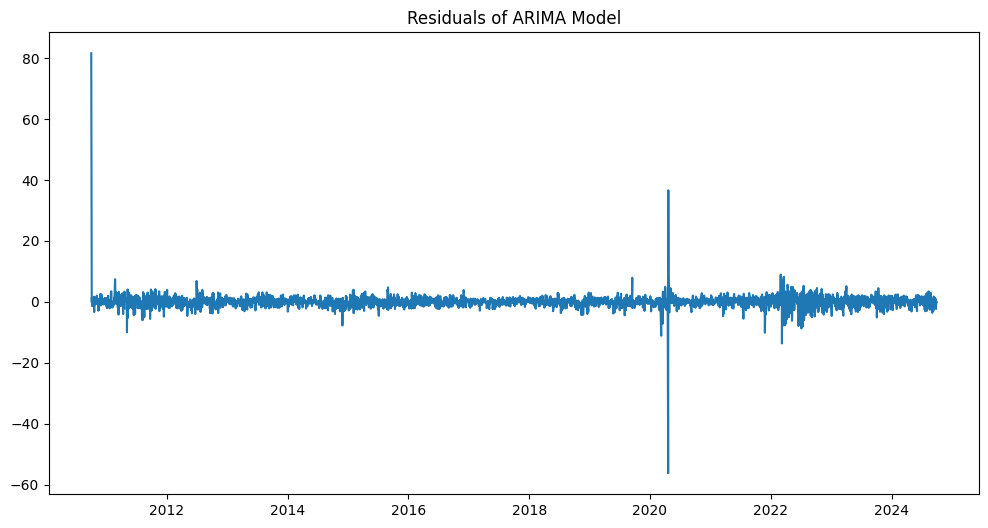

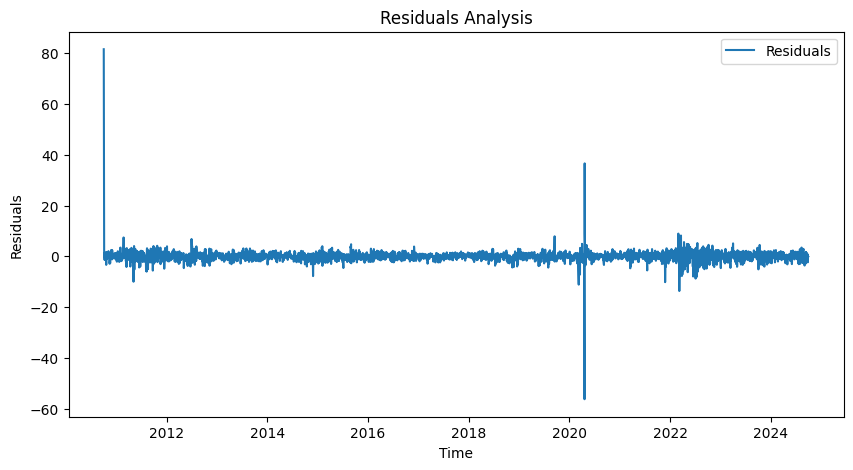

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14517.3
Distribution:                  Normal   AIC:                           29042.6
Method:            Maximum Likelihood   BIC:                           29067.2
                                        No. Observations:                 3520
Date:                Wed, Oct 02 2024   Df Residuals:                     3519
Time:                        08:13:15   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            71.2744      0.510    139.804      0.000 [ 70.275, 72.27

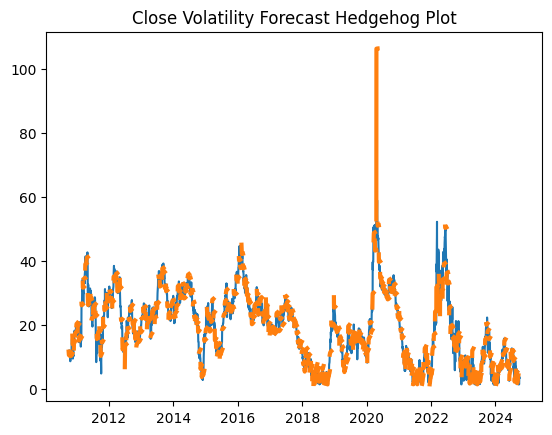

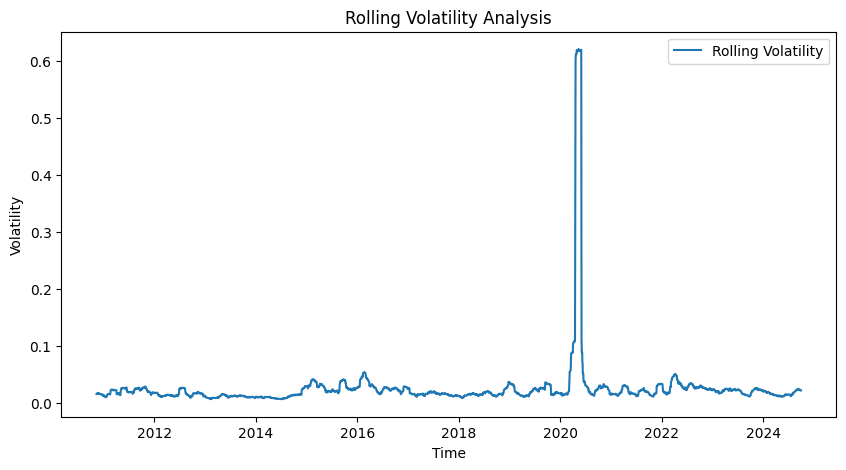

In [8]:
best_order = optimize_arima_params(df_clean)
fitted_model = fit_arima_model(df_clean, order=best_order)
residuals = analyze_residuals(fitted_model)
plot_residuals(residuals)
garch_model = fit_garch_model(df_clean)
test_arch = validate_garch_model(garch_model)

 #Calculate volatility for the whole dataset
calculate_volatility(df_clean)

# Rolling volatility analysis
rolling_vol = rolling_volatility_analysis(df_clean)


# Step 4: Perform Cross Validation on ARIMA Model

In [9]:
# Cross-validation on ARIMA model
cross_validate_arima_model(df_clean, order=best_order)

Cross-validation Mean Squared Error (MSE): nan


nan

 Step 5: Stationarity Test

In [10]:
# Test stationarity
p_value = test_stationarity(df_clean, 'Close')

ADF Statistic: -2.059364014728914
p-value: 0.2611651825485508
Critical Values: 1%, -3.4322112288397735
Critical Values: 5%, -2.8623623855085953
Critical Values: 10%, -2.5672077698860143
